In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id','item_id','rating','timestamp'])
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', names=[
    'item_id','title','release_date','video_release_date','IMDb_URL','unknown',
    'Action','Adventure','Animation','Children','Comedy','Crime','Documentary',
    'Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
    'Thriller','War','Western'
])
users = pd.read_csv("ml-100k/u.user", sep="|", names=["user_id", "age", "gender", "occupation", "zip_code"])

In [4]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


using matrix factorization technique : 
- we use embeddingg for user and movie 
- their dot prodect represents the expected rating for some movie
- we use backpropagation to update the weights

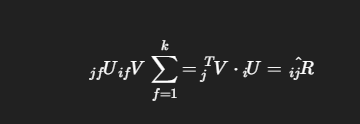

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings.user_id.values)
n_users = ratings['user_id'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings.item_id.values)
n_movies = ratings['item_id'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(943, 1682, 1.0, 5.0)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
embedding_size = 100


user = layers.Input(shape=(1,) , name='user_id')
user_emb = layers.Embedding(n_users,embedding_size,embeddings_regularizer=regularizers.l2(1e-6) , name='user_embedding_LUT')(user)
user_emb = layers.Reshape((embedding_size,))(user_emb)

movie = layers.Input(shape=(1,) , name='movie_id')
movie_emb = layers.Embedding(n_movies,embedding_size,embeddings_regularizer=regularizers.l2(1e-6),name='movie_embedding_LUT')(movie)
movie_emb = layers.Reshape((embedding_size,))(movie_emb)

x = layers.Dot(axes=1 , name='sim_measure')([user_emb,movie_emb]) 

#x = layers.Dense(64,activation='relu')(x)
#x = layers.Dense(1,activation='linear',name='predicted_rating')(x)


model = models.Model(inputs=[user,movie],outputs=x)

model.compile(
    loss = 'mse',
    optimizer = optimizers.AdamW(learning_rate=0.001),
    metrics = [metrics.RootMeanSquaredError()]
)

model.summary()
plot_model(model , show_shapes=True , show_layer_names=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_id            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding_LUT  │ (None, 1, 100)    │     94,300 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding_LUT │ (None, 1, 100)    │    168,200 │ movie_id[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 100)       │          0 │ user_embedding_L… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 100)       │          0 │ movie_embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sim_measure (Dot)   │ (None, 1)         │          0 │ reshape[0][0],    │
│                     │                   │            │ reshape_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 262,500 (1.00 MB)

 Trainable params: 262,500 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [15]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90000, 2) (90000,)
(10000, 2) (10000,)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7.3953 - root_mean_squared_error: 2.7190 - val_loss: 1.2619 - val_root_mean_squared_error: 1.1207
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0293 - root_mean_squared_error: 1.0111 - val_loss: 0.9525 - val_root_mean_squared_error: 0.9720
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8741 - root_mean_squared_error: 0.9306 - val_loss: 0.9096 - val_root_mean_squared_error: 0.9493
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7958 - root_mean_squared_error: 0.8871 - val_loss: 0.8788 - val_root_mean_squared_error: 0.9326
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7259 - root_mean_squared_error: 0.8465 - val_loss: 0.8690 - val_root_mean_squared_error: 0.9270
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6563 - root_mean_squared_error: 0.8039 - val_loss: 0.8595 - val_root_mean_squared_error: 0.9215
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━

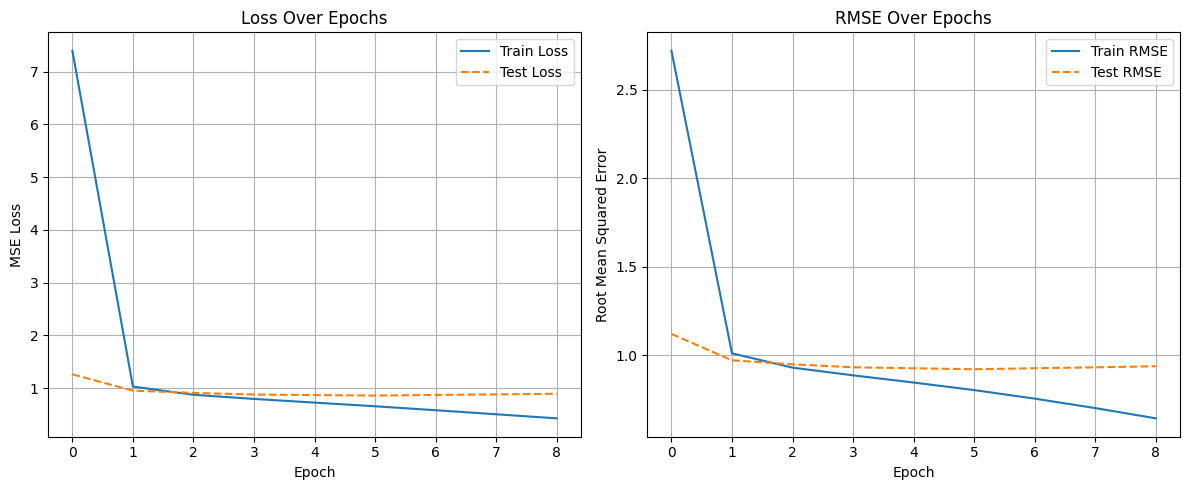

In [ ]:


early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',  
    patience=3, 
    restore_best_weights=True, 
    verbose=1
)



model.compile(loss='mse',  metrics=[metrics.RootMeanSquaredError()],
              optimizer=optimizers.Adam(learning_rate=0.001))
history = model.fit(
    x=[X_train[:, 0], X_train[:, 1]],
    y=y_train,

    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
    callbacks=[early_stopping]

)



# Plot training curves
plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss', linestyle='--')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# --- Plot RMSE ---
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Test RMSE', linestyle='--')
plt.title('RMSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
def recommend_movies_for_user(user_id, model, user_enc, movie_enc, movies, n=10):

    user_idx = user_enc.transform([user_id])[0]


    movie_indices = np.arange(n_movies)

    preds = model.predict(
        [np.full_like(movie_indices, user_idx), movie_indices],
        verbose=0
    )


    top_indices = preds.flatten().argsort()[-n:][::-1]



    recommended_movie_ids = movie_enc.inverse_transform(top_indices)

    recommendations = movies[movies['item_id'].isin(recommended_movie_ids)][['item_id', 'title']]
    recommendations = recommendations.set_index('item_id').loc[recommended_movie_ids].reset_index()

    return recommendations

In [27]:
recommend_movies_for_user(5, model, user_enc, item_enc, movies, n=10)

,item_id,title
0,172,"Empire Strikes Back, The (1980)"
1,50,Star Wars (1977)
2,169,"Wrong Trousers, The (1993)"
3,408,"Close Shave, A (1995)"
4,199,"Bridge on the River Kwai, The (1957)"
5,127,"Godfather, The (1972)"
6,168,Monty Python and the Holy Grail (1974)
7,661,High Noon (1952)
8,209,This Is Spinal Tap (1984)
9,182,GoodFellas (1990)
